# Understanding the execution flow from `LightningQubit`

In [95]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

## Approach 1: choosing a tape

In [96]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[0, 1]),
    qml.DoubleExcitation(phi, wires=[0, 1, 2, 3]),
    qml.Hadamard(wires=[1]),
    qml.CNOT(wires=[0, 1]),
    qml.DoubleExcitation(phi, wires=[0, 1, 2, 3]),
]

meas = [qml.expval(O1), qml.expval(O2)]

tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [97]:
tape.operations

[X(0),
 RX(0.1, wires=[0]),
 RX(0.2, wires=[1]),
 CNOT(wires=[0, 1]),
 DoubleExcitation(0.2, wires=[0, 1, 2, 3]),
 Hadamard(wires=[1]),
 CNOT(wires=[0, 1]),
 DoubleExcitation(0.2, wires=[0, 1, 2, 3])]

In [98]:
tape.observables

[I(0), Z(1)]

In [99]:
tape.measurements

[expval(I(0)), expval(Z(1))]

In [100]:
tape.wires

<Wires = [0, 1, 2, 3]>

## Approach 2: choosing a circuit

In [7]:
from functools import partial
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane.tape import QuantumScript, QuantumTape

dev = qml.device("lightning.qubit", wires=4)


@qml.qnode(dev)
def circuit(angles):
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(angles[0], 0)
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 1])
    qml.RX(angles[2], wires=0)
    qml.RZ(angles[1], wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RZ(-angles[1], wires=2)
    qml.CNOT(wires=[1, 0])
    qml.Hadamard(wires=1)
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


angles = [0.1, 0.3, 0.5]
# qnode = qml.QNode(circuit, dev)
# qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
# plt.show()

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None



In [8]:
circuit(angles=angles)

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=<QuantumScript: wires=[1, 2, 0], params=0>

Frisus log: execute_and_compute_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=True, use_device_gradient=True, use_device_jacobian_product=False, gradient_method='adjoint', gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x7D540474E9E0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface='autograd', derivative_order=1)
circuits=(<QuantumScript: wires=[1, 2, 0], params=0>,)



0.8253356149096776

In [9]:
dev.preprocess()

(TransformProgram(validate_measurements, validate_observables, validate_device_wires, mid_circuit_measurements, decompose, broadcast_expand),
 ExecutionConfig(grad_on_execution=True, use_device_gradient=False, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x7D540474E9E0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface=None, derivative_order=1))

In [10]:
dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 2, 3], params=4>,)



(1.0, 0.0292348722803637)

## Learning from `LightningQubit` using Python API

In [101]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [102]:
obj = LightningQubit(wires=tape.wires)

In [103]:
obj.tracker

In [104]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 2, 3], params=4>,)



(1.0, 0.0292348722803637)

## Testing `LightningTensor` 

In [105]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = 10
cutoff = 0.0

In [106]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [107]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [108]:
obj._interface.state

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

In [110]:
obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

In [111]:
program, config = obj.preprocess()

In [112]:
config.device_options

{'apply_reverse_lightcone': None,
 'backend': 'quimb',
 'c_dtype': numpy.complex128,
 'cutoff': 0.0,
 'method': 'mps',
 'max_bond_dim': 10,
 'measure_algorithm': None,
 'return_tn': False,
 'rehearse': False}

In [113]:
obj._interface._verbosity = True

obj.execute(circuits=tape)

LOG: execute called with:
circuits=(<QuantumScript: wires=[0, 1, 2, 3], params=4>,)

LOG: resetting the MPS

LOG: applying X(0) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_5fb979AAADW', 'k0'), tags=oset(['0', '1', '2', '3', 'I0', 'PSI0', 'GATE_0'])),
    Tensor(shape=(1, 1, 2), inds=('_5fb979AAADW', '_5fb979AAADX', 'k1'), tags=oset(['0', '1', '2', '3', 'I1', 'PSI0'])),
    Tensor(shape=(1, 1, 2), inds=('_5fb979AAADX', '_5fb979AAADY', 'k2'), tags=oset(['0', '1', '2', '3', 'I2', 'PSI0'])),
    Tensor(shape=(1, 2), inds=('_5fb979AAADY', 'k3'), tags=oset(['0', '1', '2', '3', 'I3', 'PSI0'])),
], tensors=4, indices=7, L=4, max_bond=2)

LOG: applying RX(0.1, wires=[0]) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_5fb979AAADW', 'k0'), tags=oset(['0', '1', '2', '3', 'I0', 'PSI0', 'GATE_0', 'GATE_1'])),
    Tensor(shape=(1, 1, 2), inds=('_5fb979AAADW', '_5fb979AAADX', 'k1'), tags=oset(['0',

(0.9999999999999984, 0.029234872280362922)

In [27]:
obj._interface._circuitMPS

<Circuit(n=4, num_gates=6, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [28]:
obj._interface._circuitMPS

<Circuit(n=4, num_gates=6, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [29]:
obj._interface._wires

<Wires = [0, 1, 2, 3]>

In [30]:
# obj.compute_derivatives(tape)

In [31]:
# obj._interface.state_to_array()

# Playing with `quimb`

In [114]:
wires = Wires(range(10))

init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)

qc = qtn.CircuitMPS(psi0=init_state)

op = qml.X(wires=[0])

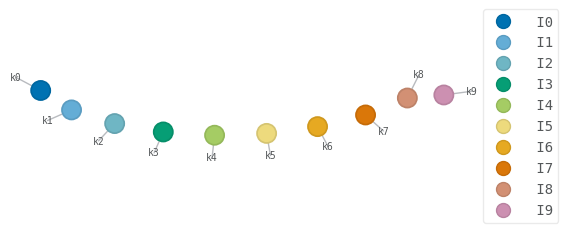

In [115]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [116]:
qc.psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=2)

In [117]:
qc.__dict__

{'_psi': MatrixProductState(tensors=10, indices=19, L=10, max_bond=2),
 'N': 10,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_conditionals': {}}

In [118]:
qc.__dict__

{'_psi': MatrixProductState(tensors=10, indices=19, L=10, max_bond=2),
 'N': 10,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_conditionals': {}}